In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader

# For visualization
import matplotlib.pyplot as plt

# For Numerical computations
import numpy as np

# This is need when you want to execute the package from another folder
import sys
sys.path.append(r"C:\Users\Usuario\OneDrive - Grabalfa Pre-Press Solutions, S.L.U\Escritorio\Jupyter\01 - Demoireing Images\Training_Package")

from visualizer import *
from dataset import TIP2018_load_data
from train_functions import *
from model import *

# # 1. Definir la semilla (opcional) ------------------------------------------------------------------------------------------------
seed = 42
set_all_seed(seed)

# # 2. To define bath size and Train and Validation Loaders -------------------------------------------------------------------------
batch_size = 1

# # Training Set
# # "C:\Users\Usuario\OneDrive - Grabalfa Pre-Press Solutions, S.L.U\Documentos\Datasets\TIP2018\trainData"
# train_root = r"C:\Users\Usuario\Datasets\TIP-2018\trainData"
# train_loader = TIP2018_load_data(train_root, batch_size, seed_generator=seed, shuffle=True)#, max_images = 1000)

# Validation Set also for Visualization
val_root = r"C:\Users\Usuario\Datasets\TIP-2018\valData"
val_loader = TIP2018_load_data(val_root, batch_size, rotation=False, shuffle=False) #, max_images = 100)

Pares utilizables: 813


# <FONT COLOR=BLUE> Model Architecture </FONT>

The model output was modified to identify get the bottleneck.

In [2]:
from torch.autograd import forward_ad
import torch
import torch.nn as nn
import torch.nn.functional as F

def f(x):
  return 0.08*(2 / (1 + torch.exp(-x)) - 1)
    
# -------------------------------------------------------------
#  Bloque básico Conv → Normalización → SiLU
# -------------------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()
        self.norm = nn.GroupNorm(8, out_ch)

    def forward(self, x):
        h = self.conv1(x)
        h = self.norm(h)
        h = self.act(h)
        return h


# -------------------------------------------------------------
#  Downsample (conv stride 2)
# -------------------------------------------------------------
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


# -------------------------------------------------------------
#  Upsample con PixelShuffle
# -------------------------------------------------------------
class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, padding=1)
        self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.ps(x)
        return x


# -------------------------------------------------------------
#                    U-NET COMPLETA (sin timestep)
# -------------------------------------------------------------
class UNetMoire(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()

        idx = 3
        # -----------------------------
        # Encoder
        # -----------------------------
        self.enc1 = ConvBlock(3, base_ch)
        self.down1 = Downsample(base_ch)     # 256 → 128

        self.enc2 = ConvBlock(base_ch, base_ch*2*idx)
        self.down2 = Downsample(base_ch*2*idx)   # 128 → 64

        self.enc3 = ConvBlock(base_ch*2*idx, base_ch*4*idx)
        self.down3 = Downsample(base_ch*4*idx)   # 64 → 32

        self.enc4 = ConvBlock(base_ch*4*idx, base_ch*8*idx)
        self.down4 = Downsample(base_ch*8*idx)   # 32 → 16

        # -----------------------------
        # Bottleneck
        # -----------------------------
        self.bottleneck = ConvBlock(base_ch*8*idx, base_ch*8*idx)

        # -----------------------------
        # Decoder
        # -----------------------------
        self.up4 = Upsample(base_ch*8*idx, base_ch*4*idx)
        self.dec4 = ConvBlock(base_ch*8*idx + base_ch*4*idx, base_ch*4*idx)

        self.up3 = Upsample(base_ch*4*idx, base_ch*2*idx)
        self.dec3 = ConvBlock(base_ch*4*idx + base_ch*2*idx, base_ch*2*idx)

        self.up2 = Upsample(base_ch*2*idx, base_ch*idx)
        self.dec2 = ConvBlock(base_ch*2*idx + base_ch*idx, base_ch*idx)

        self.up1 = Upsample(base_ch*idx, base_ch)
        self.dec1 = ConvBlock(base_ch + base_ch, base_ch)

        # salida
        self.out_conv = nn.Conv2d(base_ch, 3, 1)
        self.final_act = nn.Tanh()

    # ---------------------------------------------------------
    def forward(self, x):
        """
        x: (B, 3, 256, 256)
        """
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))
        e4 = self.enc4(self.down3(e3))

        # Bottleneck
        b = self.bottleneck(self.down4(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        #return self.final_act(self.out_conv(d1))
        return f(self.final_act(self.out_conv(d1))), b

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.Unet = UNetMoire()

    def forward(self, y_t):
        pred, bn = self.Unet(y_t)
        
        out = y_t + pred*y_t
        
        return out, pred, y_t, bn


# <FONT COLOR=BLUE> LOADING THE MODEL </FONT>

In [3]:
model = Net().cuda()

check_point = torch.load(r"checkpoints\model_epoch160.pth", weights_only=False)

model.load_state_dict(check_point['model_state_dict'])
print()

In [4]:
def f(x):
  return 0.08*(2 / (1 + torch.exp(-x)) - 1)

## <FONT COLOR=BLUE> Generating paths </FONT>

In [9]:
# Number of images (trajectories)
n_images = 30

# Number of iterative steps
n_steps = 50

# List to store trajectories (one per image)
BN = []
BN_r = []

# Iterate over the validation loader
for idx, (X, Y) in enumerate(val_loader):

    # Stop after n_images
    if idx == n_images:
        break

    # Move to GPU
    X, Y = X.cuda(), Y.cuda()

    # Initial condition
    y0 = X # Fully Moiré

    # List to store bottlenecks for ONE image
    bottlenecks = []
    bottlenecks_r = []

    # Clone initial state
    yt = y0.clone()
    yt_r = y0.clone()
    
    for step in range(n_steps):
        # To save the representation of Y in the latent Space
        if step == n_steps-1:
            img_final = yt.clone()
            
            yt = Y.clone()
            yt_r = Y.clone()
            
        with torch.no_grad():
            yt_actual = yt.clone()
            
            yt, at, _, bn = model(yt)

            # Update yt (iterative dynamics)
            #yt = yt + at * yt

            # Take only the first image in the batch
            bn = bn[0]

            # Flatten bottleneck: (C, H, W) → (C*H*W)
            bn = bn.view(-1)

            bottlenecks.append(bn)

            # For clean images ############
            _, _, _, bn_r = model(yt_r)

            # Take only the first image in the batch
            bn_r = bn_r[0]

            # Flatten bottleneck: (C, H, W) → (C*H*W)
            bn_r = bn_r.view(-1)
            
            bottlenecks_r.append(bn_r)

            # if step == 0:
            #     print(torch.sum(torch.isclose(bn, bn_r, rtol=0))/bn.numel())

            # Updating the next position using the formula
            yt_r = yt_r + f((Y - yt_r)/(yt_r + 1e-8))*yt_r

            # Stop Condition
            if torch.norm(yt - yt_actual).item() < 0.05:
                break
        
    

    # Stack: (n_steps, D)
    bottlenecks = torch.stack(bottlenecks)
    bottlenecks_r = torch.stack(bottlenecks_r)

    # Save trajectory
    BN.append(bottlenecks)
    BN_r.append(bottlenecks_r)


## <FONT COLOR=BLUE> Applying Dimensionality Reduction </FONT>

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Concatenating all paths
BN_all = torch.cat(BN, dim=0)        # (n_images * n_steps, D)
BN_all_r = torch.cat(BN_r, dim=0)    # ¡CORRECTO! No uses BN_all dos veces

# Concatenate for joint embedding
BN_joint = torch.cat([BN_all, BN_all_r], dim=0)  # (2 * N, D)
BN_joint_np = BN_joint.cpu().numpy()

# Apply PCA first (reduces noise and speeds up t-SNE)
pca = PCA(n_components=min(50, BN_joint_np.shape[1]))  # seguro si D < 50
BN_joint_pca = pca.fit_transform(BN_joint_np)

# Apply t-SNE on the PCA-reduced representation
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    max_iter=1500,
    random_state=42
)
embeddings_joint = tsne.fit_transform(BN_joint_pca)

# Split back into original groups
N = BN_all.shape[0]
embeddings   = embeddings_joint[:N]      # trayectorias de la red
embeddings_r = embeddings_joint[N:]      # trayectorias deseadas

# Reshape for sequential visualization 
traj = embeddings.reshape(n_images, n_steps, 2)
traj_r = embeddings_r.reshape(n_images, n_steps, 2)

## <FONT COLOR=BLUE> Visualizing paths (30 images) </FONT>

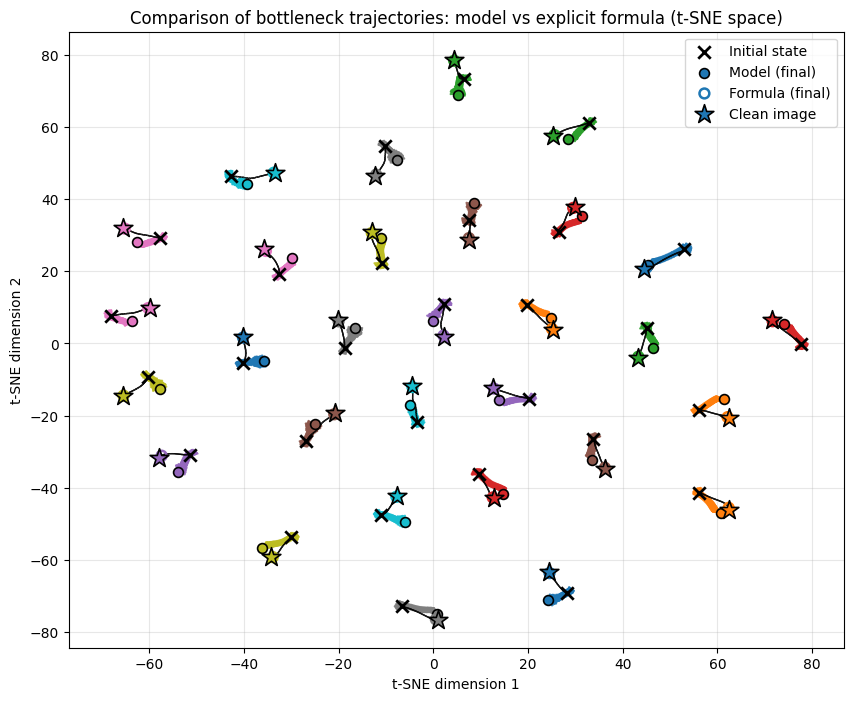

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, n_images))

for img_idx in range(n_images):

    # -------------------------
    # MODEL TRAJECTORY
    # -------------------------
    xs_m = traj[img_idx, :, 0]
    ys_m = traj[img_idx, :, 1]

    xs_m_traj = xs_m[:-1]
    ys_m_traj = ys_m[:-1]

    for t in range(len(xs_m_traj) - 1):
        plt.arrow(
            xs_m_traj[t],
            ys_m_traj[t],
            xs_m_traj[t + 1] - xs_m_traj[t],
            ys_m_traj[t + 1] - ys_m_traj[t],
            color=colors[img_idx],
            alpha=0.8,
            length_includes_head=True,
            head_width=traj.max() * 0.02,
            head_length=traj.max() * 0.02
        )

    # -------------------------
    # FORMULA TRAJECTORY
    # -------------------------
    xs_f = traj_r[img_idx, :, 0]
    ys_f = traj_r[img_idx, :, 1]

    xs_f_traj = xs_f[:-1]
    ys_f_traj = ys_f[:-1]

    for t in range(len(xs_f_traj) - 1):
        plt.arrow(
            xs_f_traj[t],
            ys_f_traj[t],
            xs_f_traj[t + 1] - xs_f_traj[t],
            ys_f_traj[t + 1] - ys_f_traj[t],
            color='black', #colors[img_idx],
            alpha=0.8,
            linestyle="dashed",
            length_includes_head=True,
            head_width=traj.max() * 0.0,
            head_length=traj.max() * 0.0
        )

    # -------------------------
    # INITIAL STATE (shared)
    # -------------------------
    plt.scatter(
        xs_m_traj[0],
        ys_m_traj[0],
        marker="x",
        s=80,
        linewidths=2,
        color="black",
        label="Initial state" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (MODEL)
    # -------------------------
    plt.scatter(
        xs_m[-2],
        ys_m[-2],
        marker="o",
        s=50,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Model (final)" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (FORMULA)
    # -------------------------
    plt.scatter(
        xs_f[-2],
        ys_f[-2],
        marker="o",
        s=50,
        facecolors="none",
        edgecolors=colors[img_idx],
        linewidths=1.8,
        label="Formula (final)" if img_idx == 0 else None
    )

    # -------------------------
    # CLEAN IMAGE (shared, not connected)
    # -------------------------
    plt.scatter(
        xs_m[-1],
        ys_m[-1],
        marker="*",
        s=200,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Clean image" if img_idx == 0 else None
    )


# -------------------------
# FIGURE SETTINGS
# -------------------------
plt.title("Comparison of bottleneck trajectories: model vs explicit formula (t-SNE space)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

plt.show()


## <FONT COLOR=BLUE> Visualizing paths (20 images) </FONT>

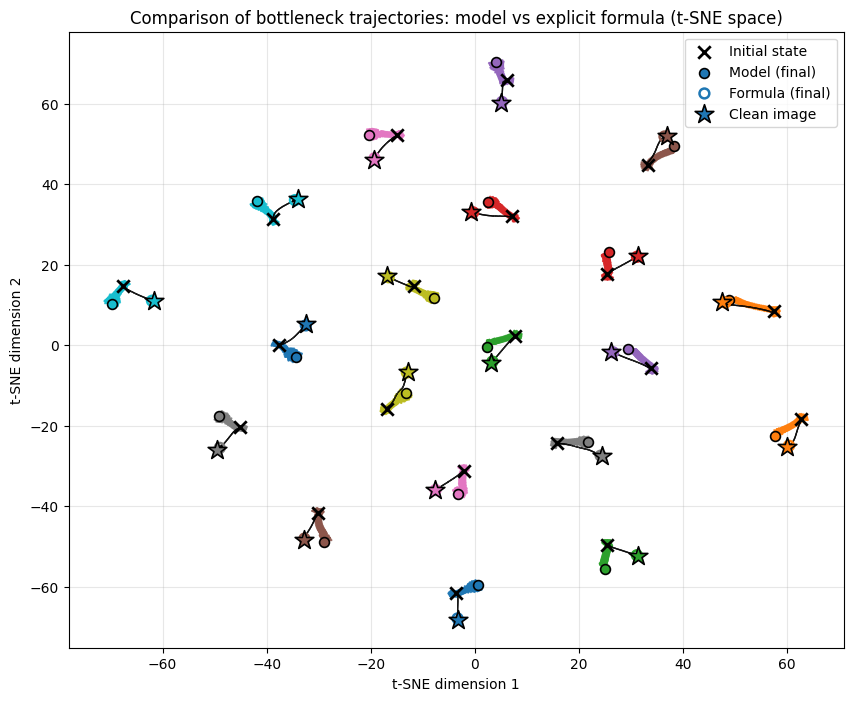

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, n_images))

for img_idx in range(n_images):

    # -------------------------
    # MODEL TRAJECTORY
    # -------------------------
    xs_m = traj[img_idx, :, 0]
    ys_m = traj[img_idx, :, 1]

    xs_m_traj = xs_m[:-1]
    ys_m_traj = ys_m[:-1]

    for t in range(len(xs_m_traj) - 1):
        plt.arrow(
            xs_m_traj[t],
            ys_m_traj[t],
            xs_m_traj[t + 1] - xs_m_traj[t],
            ys_m_traj[t + 1] - ys_m_traj[t],
            color=colors[img_idx],
            alpha=0.8,
            length_includes_head=True,
            head_width=traj.max() * 0.02,
            head_length=traj.max() * 0.02
        )

    # -------------------------
    # FORMULA TRAJECTORY
    # -------------------------
    xs_f = traj_r[img_idx, :, 0]
    ys_f = traj_r[img_idx, :, 1]

    xs_f_traj = xs_f[:-1]
    ys_f_traj = ys_f[:-1]

    for t in range(len(xs_f_traj) - 1):
        plt.arrow(
            xs_f_traj[t],
            ys_f_traj[t],
            xs_f_traj[t + 1] - xs_f_traj[t],
            ys_f_traj[t + 1] - ys_f_traj[t],
            color='black', #colors[img_idx],
            alpha=0.8,
            linestyle="dashed",
            length_includes_head=True,
            head_width=traj.max() * 0.0,
            head_length=traj.max() * 0.0
        )

    # -------------------------
    # INITIAL STATE (shared)
    # -------------------------
    plt.scatter(
        xs_m_traj[0],
        ys_m_traj[0],
        marker="x",
        s=80,
        linewidths=2,
        color="black",
        label="Initial state" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (MODEL)
    # -------------------------
    plt.scatter(
        xs_m[-2],
        ys_m[-2],
        marker="o",
        s=50,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Model (final)" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (FORMULA)
    # -------------------------
    plt.scatter(
        xs_f[-2],
        ys_f[-2],
        marker="o",
        s=50,
        facecolors="none",
        edgecolors=colors[img_idx],
        linewidths=1.8,
        label="Formula (final)" if img_idx == 0 else None
    )

    # -------------------------
    # CLEAN IMAGE (shared, not connected)
    # -------------------------
    plt.scatter(
        xs_m[-1],
        ys_m[-1],
        marker="*",
        s=200,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Clean image" if img_idx == 0 else None
    )


# -------------------------
# FIGURE SETTINGS
# -------------------------
plt.title("Comparison of bottleneck trajectories: model vs explicit formula (t-SNE space)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

plt.show()


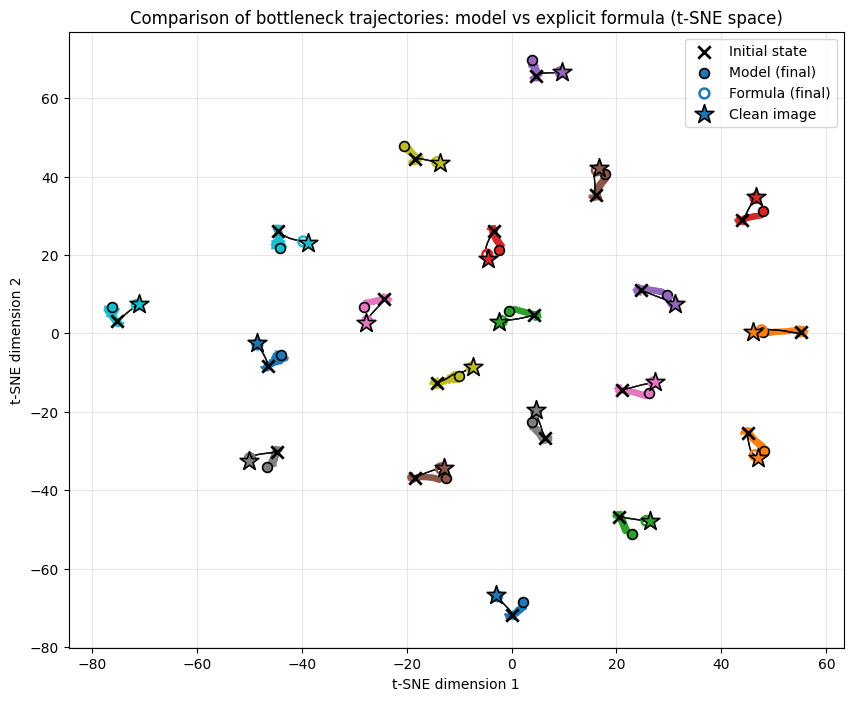

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, n_images))

for img_idx in range(n_images):

    # -------------------------
    # MODEL TRAJECTORY
    # -------------------------
    xs_m = traj[img_idx, :, 0]
    ys_m = traj[img_idx, :, 1]

    xs_m_traj = xs_m[:-1]
    ys_m_traj = ys_m[:-1]

    for t in range(len(xs_m_traj) - 1):
        plt.arrow(
            xs_m_traj[t],
            ys_m_traj[t],
            xs_m_traj[t + 1] - xs_m_traj[t],
            ys_m_traj[t + 1] - ys_m_traj[t],
            color=colors[img_idx],
            alpha=0.8,
            length_includes_head=True,
            head_width=traj.max() * 0.02,
            head_length=traj.max() * 0.02
        )

    # -------------------------
    # FORMULA TRAJECTORY
    # -------------------------
    xs_f = traj_r[img_idx, :, 0]
    ys_f = traj_r[img_idx, :, 1]

    xs_f_traj = xs_f[:-1]
    ys_f_traj = ys_f[:-1]

    for t in range(len(xs_f_traj) - 1):
        plt.arrow(
            xs_f_traj[t],
            ys_f_traj[t],
            xs_f_traj[t + 1] - xs_f_traj[t],
            ys_f_traj[t + 1] - ys_f_traj[t],
            color='black', #colors[img_idx],
            alpha=0.8,
            linestyle="dashed",
            length_includes_head=True,
            head_width=traj.max() * 0.0,
            head_length=traj.max() * 0.0
        )

    # -------------------------
    # INITIAL STATE (shared)
    # -------------------------
    plt.scatter(
        xs_m_traj[0],
        ys_m_traj[0],
        marker="x",
        s=80,
        linewidths=2,
        color="black",
        label="Initial state" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (MODEL)
    # -------------------------
    plt.scatter(
        xs_m[-2],
        ys_m[-2],
        marker="o",
        s=50,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Model (final)" if img_idx == 0 else None
    )

    # -------------------------
    # FINAL POINT (FORMULA)
    # -------------------------
    plt.scatter(
        xs_f[-2],
        ys_f[-2],
        marker="o",
        s=50,
        facecolors="none",
        edgecolors=colors[img_idx],
        linewidths=1.8,
        label="Formula (final)" if img_idx == 0 else None
    )

    # -------------------------
    # CLEAN IMAGE (shared, not connected)
    # -------------------------
    plt.scatter(
        xs_m[-1],
        ys_m[-1],
        marker="*",
        s=200,
        color=colors[img_idx],
        edgecolors="black",
        linewidths=1.2,
        label="Clean image" if img_idx == 0 else None
    )


# -------------------------
# FIGURE SETTINGS
# -------------------------
plt.title("Comparison of bottleneck trajectories: model vs explicit formula (t-SNE space)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, alpha=0.3)

plt.show()
